Lambda School Data Science

*Unit 2 - Build Week Project*

# I. Import Libraries

In [31]:
####General Imports####
import pandas as pd
import numpy as np
from joblib import dump
import joblib
from skopt.space import Real, Categorical, Integer

####Plotting Imports####
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

####Metrics Imports###
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from shap import TreeExplainer, GradientExplainer
from sklearn.inspection import permutation_importance

####Model Imports####
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
# Transformers
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Esitmators/Predictors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

####Cross Validation Imports####
from skopt import BayesSearchCV

### Configure Settings for Imported Libraries
* Set Pandas Column Max to `None` so all columns in dataframes are displayed

In [5]:
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

# II. Variable and Function Definitions

In this section I will be defining "constant" variables as well as functions for use in later parts of the Notebook.

## Variable Definitions

* Define Dictionaries for use in replace functions
  1. `soiltype_dict` defining the 4 digit soil codes based on listed Soil Type
  2. `wilderness_area_dict` defining the Wilderness Area names based on wilderness area
  3. `cover_type_dict` defining the Cover Type based on the numbers provided in the basic dataset. 


In [6]:
# Dictionary of Soil Types to associated codes
soiltype_dict = {
    'Soil_Type1': '2702',
    'Soil_Type2': '2703',
    'Soil_Type3': '2704',
    'Soil_Type4': '2705',
    'Soil_Type5': '2706',
    'Soil_Type6': '2717',
    'Soil_Type7': '3501',
    'Soil_Type8': '3502',
    'Soil_Type9': '4201',
    'Soil_Type10': '4703',
    'Soil_Type11': '4704',
    'Soil_Type12': '4744',
    'Soil_Type13': '4758',
    'Soil_Type14': '5101',
    'Soil_Type15': '5151',
    'Soil_Type16': '6101',
    'Soil_Type17': '6102',
    'Soil_Type18': '6731',
    'Soil_Type19': '7101',
    'Soil_Type20': '7102',
    'Soil_Type21': '7103',
    'Soil_Type22': '7201',
    'Soil_Type23': '7202',
    'Soil_Type24': '7700',
    'Soil_Type25': '7701',
    'Soil_Type26': '7702',
    'Soil_Type27': '7709',
    'Soil_Type28': '7710',
    'Soil_Type29': '7745',
    'Soil_Type30': '7746',
    'Soil_Type31': '7755',
    'Soil_Type32': '7756',
    'Soil_Type33': '7757',
    'Soil_Type34': '7790',
    'Soil_Type35': '8703',
    'Soil_Type36': '8707',
    'Soil_Type37': '8708',
    'Soil_Type38': '8771',
    'Soil_Type39': '8772',
    'Soil_Type40': '8776'
}

wilderness_area_dict = {
    'Wilderness_Area1': 'Rawah Wilderness Area',
    'Wilderness_Area2': 'Neota Wilderness Area',
    'Wilderness_Area3': 'Comanche Peak Wilderness Area',
    'Wilderness_Area4': 'Cache la Poudre Wilderness Area'
}

cover_type_dict = {

    '1': 'Spruce/Fir',
    '2': 'Lodgepole Pine',
    '3': 'Ponderosa Pine',
    '4': 'Cottonwood/Willow',
    '5': 'Aspen',
    '6': 'Douglas-fir',
    '7': 'Krummholz'
}


## Function Definitions

### `revert_soil_type` function to remove Soil_Type One-hot encoding

In [7]:
def revert_soil_type(soil_columns, row):
    for col in soil_columns:
        if row[col] == 1:
            return col

### `revert_wilderness_area` function to remove Wilderness_Area One-hot encoding




In [9]:
def revert_wilderness_area(wilderness_columns, row):
    for col in wilderness_columns:
        if row[col] == 1:
            return col

### `wrangle` function for wrangling the dataset for the model. 

In [10]:
def wrangle(df):
    df = df.copy()

    # Convert the Cover Type (Target) from number representations to the strings for better presentation
    df['Cover_Type'] = df['Cover_Type'].astype(str)
    df['Cover_Type'] = df['Cover_Type'].replace(cover_type_dict)

    # Remove One Hot Encoding from Soil Type Columns
    soil_columns = [col for col in df.columns if 'Soil' in col]
    df['Soil_Type'] = df[soil_columns].apply(lambda x: revert_soil_type(soil_columns, x), axis= 1)
    df['Soil_Type'] = df['Soil_Type'].replace(soiltype_dict)
    df.drop(columns= soil_columns, inplace= True)

    # Remove One Hot Encoding from Wilderness Area Columns
    wilderness_columns = [col for col in df.columns if 'Wilderness' in col]
    df['Wilderness_Area'] = df[wilderness_columns].apply(lambda x: revert_wilderness_area(wilderness_columns, x), axis= 1)
    df['Wilderness_Area'] = df['Wilderness_Area'].replace(wilderness_area_dict)
    df.drop(columns= wilderness_columns, inplace= True)

    # Engineer the Climatic and Geological Zones from the Soil Type Code
    df['soil_code'] = df['Soil_Type'].apply(lambda x: [char for char in x])
    df['Climatic_Zone'] = df['soil_code'].apply(lambda x: x[0])
    df['Geologic_Zone'] = df['soil_code'].apply(lambda x: x[1])
    df.drop(columns= 'soil_code', inplace= True)
    
    # Engineer Euclidean distance to Nearest Water (a**2 + b**2 = c**2)
    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    
    return df

### `present_trainval_metrics` function for displaying multiple model Training and Validation metrics

In [11]:
def present_trainval_metrics(model_list, X_set, y_set):
    for model in model_list:
        print('Model being Scored:', model[0])
        print('>>Training Accuracy Score:', model[1].score(X_set[0], y_set[0]))
        print('>>Validation Accuracy Score:', model[1].score(X_set[1], y_set[1]))

### `present_test_metrics` function for displaying multiple model Test metrics

In [12]:
def present_test_metrics(model_list, X_set, y_set):
    for model in model_list:
        print('Model being Scored:', model[0])
        print('>>Testing Accuracy Score:', model[1].score(X_set, y_set))

# III. Load the Dataset and Perform Exploratory Data Analysis

In this section I will be loading the data and performing the initial Exploratory Data Analysis

## Load the Data
The data is contained in the CSV file 'covtype.csv'. 

I found the dataset on the Kaggle website here: https://www.kaggle.com/uciml/forest-cover-type-dataset

Additional details were found on the UCI site where the data was originally published: https://archive.ics.uci.edu/ml/datasets/Covertype


In [13]:
url = '../data/covtype.csv'
df_raw = pd.read_csv(url)

## Exploratory Data Analysis

In [10]:
df_raw.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

### EDA Findings:

Based on the exploration of the data, we have no observations with Null Values. However, the dataset has already been set with One Hot Encoding for Soil Type and Wilderness Area, as OHE is not advised for every model I will want to revert these to categorical columns and use a transformer to provide OHE for a any models that work best with OHE. 

The variable we will be predicting is `Cover_Type` a categorical variable containing 7 classes of "Cover Type", these cover types are the tree species which makes up the 30mX30m measured section of forest. This metric was chosen based mostly on the Kaggle description since it was the Target for a past competition, however, based on what data I have it is also the most useful to predict, since knowing the type of trees in an area of the Roosevelt National forest can be useful for forest services. The other features can be observed based on mapping data of the area, however, cover type would require a much closer inspection.

The Cover Types are numbers as follows:
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The dataset does not have any features which would provide leakage into the training process. There are no features indicating Tree or Cover type besides the Target. 

# IV. Wrangle and Split the Data

In the following section I will perform the data wrangling and will also create my Train, Validation, and Test datasets. 

## Wrangle

Using the `wrangle` function defined above, the data will be adjusted and features engineered to become the final dataset for use in models. 

Additionally perform some basic EDA to confirm the `wrangle` function returned the new dataframe as expected. 

In [15]:
df_wrangled = wrangle(df_raw)

In [13]:
df_wrangled.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area,Climatic_Zone,Geologic_Zone,Euclidean_Distance_To_Hydrology
0,2596,51,3,258,0,510,221,232,148,6279,Aspen,7745,Rawah Wilderness Area,7,7,258.000000
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen,7745,Rawah Wilderness Area,7,7,212.084889
2,2804,139,9,268,65,3180,234,238,135,6121,Lodgepole Pine,4744,Rawah Wilderness Area,4,7,275.769832
3,2785,155,18,242,118,3090,238,238,122,6211,Lodgepole Pine,7746,Rawah Wilderness Area,7,7,269.235956
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen,7745,Rawah Wilderness Area,7,7,153.003268


In [14]:
df_wrangled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  int64  
 1   Aspect                              581012 non-null  int64  
 2   Slope                               581012 non-null  int64  
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64  
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64  
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64  
 6   Hillshade_9am                       581012 non-null  int64  
 7   Hillshade_Noon                      581012 non-null  int64  
 8   Hillshade_3pm                       581012 non-null  int64  
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64  
 10  Cover_Type                          581012 non-null  object 
 11  Soil_Type                 

In [15]:
df_wrangled.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Euclidean_Distance_To_Hydrology
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,276.065482
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,217.047653
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,108.461975
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,229.477668
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,393.814677
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1418.916840


## Split into Target Vector and Feature Matrix

The target will be `'Cover_Type'`

All other variables will be considered part of the Feature Matrix



In [21]:
target =  'Cover_Type'

y = df_wrangled[target]
X = df_wrangled.drop(columns= target)

## Split into Training, Validation, and Test Sets

A separate Test dataset was not given, as such I will be performing both a Test Split and a Validation Split of the data. 

Doing the split now will ensure I do not have any Leaky Testing Processes when trying to fit the training data to the models. 

In [22]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

# Split the "train" into Train and Val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state= 42)

# V. Establish a Baseline

In this section I will determine the Baseline Metric and establish the metric I will use for the models. 

### Baseline Accuracy: Majority Class

Since this is a classification problem I will use the Marjority Class as the Baseline Accuracy score.

In [18]:
baseline_accuracy =  y_train.value_counts(normalize= True).max()

print('Baseline Accuracy:', baseline_accuracy)

Baseline Accuracy: 0.48794451054088883


The baseline accuracy of 49% is just outside of the guidlines (50-70%) for using Accuracy as the primary metric, however, based on my review of the dataset, the Kaggle documentation (the competition used accuracy), and the UCI Documentation I believe that using the Accuracy Score will be the metric for determining the best model. 

Though I will also provide the Precision, Recall, and F1 Scores for the Linear Model and the chosen tree-based model. 

# VI. Create Untuned Models

In the following section I will create the untuned models for Linear Classification (Logistic Regression) and a number of tree-based models. The best of the untuned models will move on to hyperparameter tuning to attempt to further improve their performance. 

## Linear Model

Because this is a classification problem, specifically a multi-class classification problem, the linear model used will be LogisticRegression. 

In [19]:

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    StandardScaler(),
    LogisticRegression()
    )

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Soil_Type', 'Wilderness_Area',
                                     'Climatic_Zone', 'Geologic_Zone'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Tree-based Models

I will evaluate a number of model types and will use the model with the best Accuracy Score, on the Validation data, for hypertuning.

The following are the tree-based models to be created:
* Random Forest Classifier
* XGBoost Classifier
* CatBoost Classifier

### Random Forest Model

In [21]:
# Random Forest Classifier Model
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
    )

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Soil_Type', 'Wilderness_Area',
                                      'Climatic_Zone', 'Geologic_Zone'],
                                mapping=[{'col': 'Soil_Type',
                                          'data_type': dtype('O'),
                                          'mapping': 7757     1
7700     2
7745     3
7756     4
7201     5
4758     6
6731     7
2705     8
8772     9
7202    10
2704    11
2717    12
4703    13
7746    14
7755    15
7702    16
8771    17
2706    18
4744    19
7710    20
7790    21
7102    22
4201    23
4704    24
2703    25
8776    26
7101    27
2702    28
6101    29
8707    30...
                                          'data_type': dtype('O'),
                                          'mapping': Comanche Peak Wilderness Area      1
Rawah Wilderness Area              2
Neota Wilderness Area              3
Cache la Poudre Wilderness Area    4
NaN                               -2
dt

### XGBoost Gradient Boost Model

In [22]:
eval_set = [(X_val, y_val)]

model_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42,
                  eval_set=eval_set,
                  eval_metric='merror',
                  n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

[17:59:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Soil_Type', 'Wilderness_Area',
                                      'Climatic_Zone', 'Geologic_Zone'],
                                mapping=[{'col': 'Soil_Type',
                                          'data_type': dtype('O'),
                                          'mapping': 7757     1
7700     2
7745     3
7756     4
7201     5
4758     6
6731     7
2705     8
8772     9
7202    10
2704    11
2717    12
4703    13
7746    14
7755    15
7702    16
8771    17
2706    18
4744    19
7710    20
7790    21
7102    22
4201    23
4704    24
2703    25
8776    26
7101    27
2702    28
6101    29
8707    30...
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                    

### CatBoost Gradient Boost Model

In [ ]:
cat_features =  X_train.select_dtypes('object').columns

model_catb = CatBoostClassifier(random_state=42, cat_features=cat_features)

model_catb.fit(X_train, y_train)

Learning rate set to 0.108232
0:	learn: 1.6565931	total: 1.93s	remaining: 32m 7s
1:	learn: 1.4729667	total: 3.79s	remaining: 31m 32s
2:	learn: 1.3400502	total: 5.74s	remaining: 31m 49s
3:	learn: 1.2356028	total: 7.65s	remaining: 31m 46s
4:	learn: 1.1513856	total: 9.43s	remaining: 31m 17s
5:	learn: 1.0845373	total: 11.3s	remaining: 31m 14s
6:	learn: 1.0286500	total: 13.1s	remaining: 31m 4s
7:	learn: 0.9805359	total: 15.1s	remaining: 31m 12s
8:	learn: 0.9410199	total: 17s	remaining: 31m 8s
9:	learn: 0.9042996	total: 19s	remaining: 31m 17s
10:	learn: 0.8735056	total: 20.9s	remaining: 31m 19s
11:	learn: 0.8470468	total: 22.7s	remaining: 31m 9s
12:	learn: 0.8226452	total: 24.7s	remaining: 31m 16s
13:	learn: 0.8019497	total: 26.8s	remaining: 31m 28s
14:	learn: 0.7841060	total: 28.7s	remaining: 31m 27s
15:	learn: 0.7655384	total: 30.7s	remaining: 31m 29s
16:	learn: 0.7502036	total: 32.8s	remaining: 31m 37s
17:	learn: 0.7367488	total: 34.8s	remaining: 31m 36s
18:	learn: 0.7249749	total: 36.8s	

153:	learn: 0.4772434	total: 5m 2s	remaining: 27m 42s
154:	learn: 0.4767538	total: 5m 4s	remaining: 27m 40s
155:	learn: 0.4761997	total: 5m 6s	remaining: 27m 38s
156:	learn: 0.4757206	total: 5m 8s	remaining: 27m 36s
157:	learn: 0.4753058	total: 5m 10s	remaining: 27m 34s
158:	learn: 0.4748368	total: 5m 12s	remaining: 27m 32s
159:	learn: 0.4740981	total: 5m 14s	remaining: 27m 30s
160:	learn: 0.4736014	total: 5m 16s	remaining: 27m 28s
161:	learn: 0.4727147	total: 5m 18s	remaining: 27m 26s
162:	learn: 0.4720851	total: 5m 20s	remaining: 27m 25s
163:	learn: 0.4715040	total: 5m 22s	remaining: 27m 22s
164:	learn: 0.4708315	total: 5m 24s	remaining: 27m 20s
165:	learn: 0.4698715	total: 5m 26s	remaining: 27m 19s
166:	learn: 0.4693589	total: 5m 28s	remaining: 27m 17s
167:	learn: 0.4685984	total: 5m 30s	remaining: 27m 14s
168:	learn: 0.4678359	total: 5m 32s	remaining: 27m 13s
169:	learn: 0.4671263	total: 5m 34s	remaining: 27m 10s
170:	learn: 0.4665943	total: 5m 35s	remaining: 27m 8s
171:	learn: 0.4

304:	learn: 0.4082431	total: 10m 11s	remaining: 23m 13s
305:	learn: 0.4078364	total: 10m 13s	remaining: 23m 12s
306:	learn: 0.4075446	total: 10m 15s	remaining: 23m 10s
307:	learn: 0.4073280	total: 10m 18s	remaining: 23m 9s
308:	learn: 0.4069715	total: 10m 20s	remaining: 23m 8s
309:	learn: 0.4067071	total: 10m 22s	remaining: 23m 6s
310:	learn: 0.4060847	total: 10m 24s	remaining: 23m 4s
311:	learn: 0.4059173	total: 10m 26s	remaining: 23m 2s
312:	learn: 0.4057335	total: 10m 29s	remaining: 23m
313:	learn: 0.4054699	total: 10m 31s	remaining: 22m 59s
314:	learn: 0.4051698	total: 10m 33s	remaining: 22m 58s
315:	learn: 0.4049146	total: 10m 35s	remaining: 22m 56s
316:	learn: 0.4045435	total: 10m 37s	remaining: 22m 54s
317:	learn: 0.4044024	total: 10m 39s	remaining: 22m 52s
318:	learn: 0.4042385	total: 10m 41s	remaining: 22m 50s
319:	learn: 0.4040519	total: 10m 43s	remaining: 22m 48s
320:	learn: 0.4039422	total: 10m 45s	remaining: 22m 46s
321:	learn: 0.4036912	total: 10m 47s	remaining: 22m 44s
3

452:	learn: 0.3690345	total: 15m 13s	remaining: 18m 22s
453:	learn: 0.3686680	total: 15m 15s	remaining: 18m 20s
454:	learn: 0.3685041	total: 15m 17s	remaining: 18m 18s
455:	learn: 0.3681695	total: 15m 19s	remaining: 18m 16s
456:	learn: 0.3678838	total: 15m 21s	remaining: 18m 14s
457:	learn: 0.3675595	total: 15m 23s	remaining: 18m 12s
458:	learn: 0.3674140	total: 15m 25s	remaining: 18m 10s
459:	learn: 0.3672109	total: 15m 27s	remaining: 18m 8s
460:	learn: 0.3668113	total: 15m 29s	remaining: 18m 6s
461:	learn: 0.3665150	total: 15m 31s	remaining: 18m 4s
462:	learn: 0.3663434	total: 15m 33s	remaining: 18m 2s
463:	learn: 0.3660436	total: 15m 35s	remaining: 18m
464:	learn: 0.3657798	total: 15m 37s	remaining: 17m 58s
465:	learn: 0.3655993	total: 15m 39s	remaining: 17m 56s
466:	learn: 0.3653647	total: 15m 41s	remaining: 17m 54s
467:	learn: 0.3650902	total: 15m 43s	remaining: 17m 52s
468:	learn: 0.3647809	total: 15m 45s	remaining: 17m 50s
469:	learn: 0.3646495	total: 15m 47s	remaining: 17m 48s


600:	learn: 0.3409273	total: 20m 9s	remaining: 13m 22s
601:	learn: 0.3407203	total: 20m 11s	remaining: 13m 20s
602:	learn: 0.3405473	total: 20m 13s	remaining: 13m 18s
603:	learn: 0.3403661	total: 20m 15s	remaining: 13m 16s
604:	learn: 0.3402463	total: 20m 17s	remaining: 13m 14s
605:	learn: 0.3400534	total: 20m 19s	remaining: 13m 12s
606:	learn: 0.3397809	total: 20m 21s	remaining: 13m 10s
607:	learn: 0.3396742	total: 20m 23s	remaining: 13m 8s
608:	learn: 0.3394889	total: 20m 25s	remaining: 13m 6s
609:	learn: 0.3394168	total: 20m 27s	remaining: 13m 4s
610:	learn: 0.3392515	total: 20m 29s	remaining: 13m 2s
611:	learn: 0.3391368	total: 20m 31s	remaining: 13m
612:	learn: 0.3390547	total: 20m 33s	remaining: 12m 58s
613:	learn: 0.3389543	total: 20m 35s	remaining: 12m 56s
614:	learn: 0.3388416	total: 20m 37s	remaining: 12m 54s
615:	learn: 0.3387474	total: 20m 39s	remaining: 12m 52s
616:	learn: 0.3385713	total: 20m 41s	remaining: 12m 50s
617:	learn: 0.3384731	total: 20m 43s	remaining: 12m 48s
6

749:	learn: 0.3188982	total: 25m 6s	remaining: 8m 22s
750:	learn: 0.3186846	total: 25m 8s	remaining: 8m 20s
751:	learn: 0.3186122	total: 25m 10s	remaining: 8m 18s
752:	learn: 0.3184716	total: 25m 12s	remaining: 8m 16s
753:	learn: 0.3182230	total: 25m 14s	remaining: 8m 14s
754:	learn: 0.3179809	total: 25m 16s	remaining: 8m 12s
755:	learn: 0.3178692	total: 25m 18s	remaining: 8m 10s
756:	learn: 0.3177427	total: 25m 20s	remaining: 8m 8s
757:	learn: 0.3176049	total: 25m 22s	remaining: 8m 6s
758:	learn: 0.3174505	total: 25m 24s	remaining: 8m 4s
759:	learn: 0.3173122	total: 25m 26s	remaining: 8m 2s
760:	learn: 0.3172039	total: 25m 29s	remaining: 8m
761:	learn: 0.3171046	total: 25m 31s	remaining: 7m 58s
762:	learn: 0.3169595	total: 25m 33s	remaining: 7m 56s
763:	learn: 0.3167974	total: 25m 35s	remaining: 7m 54s
764:	learn: 0.3167604	total: 25m 37s	remaining: 7m 52s
765:	learn: 0.3166633	total: 25m 40s	remaining: 7m 50s
766:	learn: 0.3164336	total: 25m 42s	remaining: 7m 48s
767:	learn: 0.316335

900:	learn: 0.3017152	total: 30m 21s	remaining: 3m 20s
901:	learn: 0.3014318	total: 30m 23s	remaining: 3m 18s
902:	learn: 0.3013240	total: 30m 25s	remaining: 3m 16s
903:	learn: 0.3011963	total: 30m 27s	remaining: 3m 14s
904:	learn: 0.3011287	total: 30m 29s	remaining: 3m 12s
905:	learn: 0.3010799	total: 30m 31s	remaining: 3m 10s
906:	learn: 0.3010127	total: 30m 34s	remaining: 3m 8s
907:	learn: 0.3009521	total: 30m 36s	remaining: 3m 6s
908:	learn: 0.3008308	total: 30m 38s	remaining: 3m 4s
909:	learn: 0.3006231	total: 30m 40s	remaining: 3m 2s
910:	learn: 0.3004147	total: 30m 42s	remaining: 2m 59s
911:	learn: 0.3003514	total: 30m 44s	remaining: 2m 57s
912:	learn: 0.3002580	total: 30m 46s	remaining: 2m 55s
913:	learn: 0.3001991	total: 30m 48s	remaining: 2m 53s
914:	learn: 0.3001037	total: 30m 50s	remaining: 2m 51s
915:	learn: 0.2999224	total: 30m 52s	remaining: 2m 49s
916:	learn: 0.2998414	total: 30m 54s	remaining: 2m 47s
917:	learn: 0.2997317	total: 30m 56s	remaining: 2m 45s
918:	learn: 0.

# VII. Check Metrics for Unconstrained Models

In [ ]:
model_list = [['Logistic Regression', model_lr], 
              ['Random Forest', model_rf],
              ['XGBoost', model_xgb],
              ['CatBoost', model_catb]]

X_datasets = [X_train,
              X_val]

y_datasets = [y_train, 
              y_val]

In [ ]:
present_trainval_metrics(model_list, X_datasets, y_datasets)

Model being Scored: Logistic Regression
>>Training Accuracy Score: 0.7244201381642782
>>Validation Accuracy Score: 0.72375928332315
>>Test Accuracy Score: 0.72375928332315
Model being Scored: Random Forest
>>Training Accuracy Score: 0.9999978485786635
>>Validation Accuracy Score: 0.9598977651179401
>>Test Accuracy Score: 0.9598977651179401
Model being Scored: XGBoost
>>Training Accuracy Score: 0.8906475563080749
>>Validation Accuracy Score: 0.8791769575656394
>>Test Accuracy Score: 0.8791769575656394
Model being Scored: CatBoost
>>Training Accuracy Score: 0.8911015062100777
>>Validation Accuracy Score: 0.8861475177060834
>>Test Accuracy Score: 0.8861475177060834


# VIII. Model Tuning

### Tune the Logistic Regression Model
Parameters to Tune:
* C

In [ ]:
params = {
    'logisticregression__C': Real(0.25,1.25)
}

optimizer = BayesSearchCV(model_lr,
                          # (parameter space, # of evaluations)
                          [(params, 50)],
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

optimizer.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   52.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.1s finished


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('onehotencoder',
                                         OneHotEncoder(cols=['Soil_Type',
                                                             'Wilderness_Area',
                                                             'Climatic_Zone',
                                                             'Geologic_Zone'],
                                                       use_cat_names=True)),
                                        ('standardscaler', StandardScaler()),
                                        ('logisticregression',
                                         LogisticRegression())]),
              n_jobs=-1,
              search_spaces=[({'logisticregression__C': Real(low=0.25, high=1.25, prior='uniform', transform='identity')},
                              50)],
              verbose=1)

In [ ]:
print('Best Score:', best_score_lr)
print('Best Parameters:', str(best_params_lr))

val. score: 0.724355595524183
best params: OrderedDict([('logisticregression__C', 1.0808991573896445)])


### Tune the Random Forest Classifier Model
Parameters to Tune:
* Max Depth
* Number Estimators
* Max Samples

In [ ]:
params = {
    'randomforestclassifier__max_depth': Integer(25,200),
    'randomforestclassifier__n_estimators': Integer(100,300),
    'randomforestclassifier__max_samples': Real(0.25,1.0)
}

optimizer = BayesSearchCV(model_rf,
                          # (parameter space, # of evaluations)
                          [(params, 50)],
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

optimizer.fit(X_train, y_train)

best_score_rf = optimizer.best_score_
best_params_rf = optimizer.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.3s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.1min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.1min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.2min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.3s remaining:   42.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.5min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.4min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.1s remaining:   57.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.5s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.4min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.1min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.0min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.1min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


In [ ]:
print('Best Score:', best_score_rf)
print('Best Parameters:', str(best_params_rf))

Best Score: 0.956330449711602
Best Parameters: OrderedDict([('randomforestclassifier__max_depth', 100), ('randomforestclassifier__max_samples', 0.99), ('randomforestclassifier__n_estimators', 200)])


# IX. Create Best Tuned Models and Check the New Metrics

## Create Linear Regression best model

In [ ]:
print('Best Parameters:', str(best_params_lr))

In [24]:
best_model_lr = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    StandardScaler(),
    LogisticRegression(C= 1.0808991573896445)
    )

best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Soil_Type', 'Wilderness_Area',
                                     'Climatic_Zone', 'Geologic_Zone'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1.0808991573896445))])

## Create Random Forest Classifier best model

In [ ]:
print('Best Parameters:', str(best_params_rf))

In [50]:
best_model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state= 42,
        n_jobs= -1,
        max_depth= 100,
        max_samples= 0.99,
        n_estimators= 200
        )
    )

best_model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Soil_Type', 'Wilderness_Area',
                                      'Climatic_Zone', 'Geologic_Zone'],
                                mapping=[{'col': 'Soil_Type',
                                          'data_type': dtype('O'),
                                          'mapping': 7757     1
7700     2
7745     3
7756     4
7201     5
4758     6
6731     7
2705     8
8772     9
7202    10
2704    11
2717    12
4703    13
7746    14
7755    15
7702    16
8771    17
2706    18
4744    19
7710    20
7790    21
7102    22
4201    23
4704    24
2703    25
8776    26
7101    27
2702    28
6101    29
8707    30...
Neota Wilderness Area              3
Cache la Poudre Wilderness Area    4
NaN                               -2
dtype: int64},
                                         {'col': 'Climatic_Zone',
                                          'data_type': dtype('O'),
                                          'mappi

## Check Accuracy Metrics for the "Best Models" after tuning

In [42]:
best_model_list = [['Logistic Regression', best_model_lr], 
              ['Random Forest', best_model_rf]]

X_datasets = [X_train,
              X_val]

y_datasets = [y_train, 
              y_val]

present_trainval_metrics(best_model_list, X_datasets, y_datasets)

Model being Scored: Logistic Regression
>>Training Accuracy Score: 0.7244308952709607
>>Validation Accuracy Score: 0.7238195227317711
Model being Scored: Random Forest
>>Training Accuracy Score: 1.0
>>Validation Accuracy Score: 0.9604743423147423


## Check Additional Metrics
Although not necessary it will be interesting to see the Precision, Recall, and F1 scores for the "Best Model", for my purposes I have chosen the Random Forest Classifier which maintained the highest Accuracy score in the modeling

In [44]:
print(classification_report(y_val, best_model_rf.predict(X_val)))

                   precision    recall  f1-score   support

            Aspen       0.94      0.80      0.87      1995
Cottonwood/Willow       0.92      0.85      0.88       526
      Douglas-fir       0.94      0.91      0.93      3489
        Krummholz       0.97      0.96      0.97      4015
   Lodgepole Pine       0.96      0.98      0.97     56500
   Ponderosa Pine       0.95      0.97      0.96      7121
       Spruce/Fir       0.97      0.95      0.96     42557

         accuracy                           0.96    116203
        macro avg       0.95      0.92      0.93    116203
     weighted avg       0.96      0.96      0.96    116203



# X. Check Importances

## Logistic Regression Feature Importances

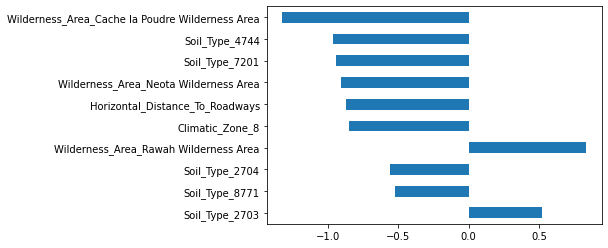

In [32]:
lr_coefs = best_model_lr.named_steps['logisticregression'].coef_[0]
lr_features = best_model_lr.named_steps['onehotencoder'].get_feature_names()
lr_importances = pd.Series(lr_coefs, index=lr_features)

lr_importances.sort_values(key=lambda x: abs(x)).tail(10).plot(kind='barh')
plt.show()

## Random Forest Classifier Importances

### Best Model Feature Importances

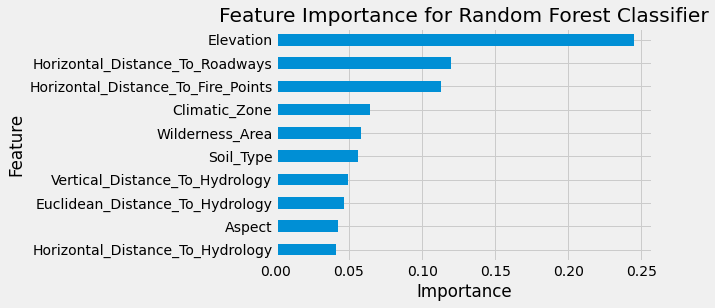

In [55]:
rf_importances = best_model_rf.named_steps['randomforestclassifier'].feature_importances_
rf_features = X_train.columns
rf_feature_importances = pd.Series(rf_importances, index=rf_features)

rf_feature_importances.sort_values().tail(10).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()

### Best Model Permutation Importances

**Retrieve and Setup the Permutation Importances for Plotting**

In [51]:
rf_perm_importances = permutation_importance(best_model_rf,
                                            X_val,
                                            y_val,
                                            n_jobs=-1,
                                            random_state=42)

perm_imp_data = {'importances_mean' : rf_perm_importances['importances_mean'],
        'importances_std' : rf_perm_importances['importances_std']}

rf_perm_imp_df = pd.DataFrame(perm_imp_data, index=X_val.columns)
rf_perm_imp_df.sort_values(by='importances_mean', inplace=True)

**Plot the Permutation Importances**

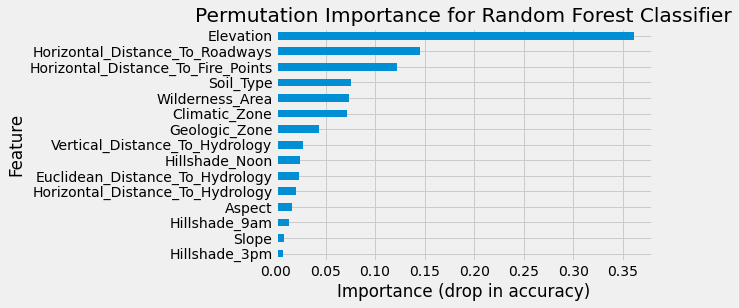

In [53]:
rf_perm_imp_df['importances_mean'].plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation Importance for Random Forest Classifier')
plt.show()

### Best Model Shap inspection

For the shap inspection I will need to create a non-Pipeline model. Below will build the 

In [35]:
# Define the transformers and predictor
shap_transformer_rf = OrdinalEncoder()
shap_model_rf = RandomForestClassifier(random_state= 42,
                                        n_jobs= -1,
                                        max_depth= 100,
                                        max_samples= 0.99,
                                        n_estimators= 200
                                        )

# Fit and Transform the dataset for the Shap model
X_train_shap = shap_transformer_rf.fit_transform(X_train)
shap_model_rf.fit(X_train_shap, y_train)



RandomForestClassifier(max_depth=100, max_samples=0.99, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [37]:
# Create a Random Index for checking and retrieve the Row
shap_index = np.random.randint(1, len(X_train_shap))-1
print('Row Used:', shap_index)
shap_row = X_train_shap.iloc[[shap_index]]

# Create the Explainer and retrieve the Shap Values
explainer = shap.TreeExplainer(shap_model_rf) # <-- Does not like pipelines
shap_values = explainer.shap_values(shap_row)

shap_values

Row Used: 67310


[array([[-0.01847471,  0.00080435,  0.0005022 ,  0.00059896, -0.00091501,
         -0.0051798 ,  0.00282247, -0.00029299,  0.00302759,  0.00036324,
          0.00053561,  0.00206685, -0.0001462 , -0.00270144,  0.00085834]]),
 array([[-3.14744586e-03,  2.31373344e-04,  3.04812424e-04,
         -2.41304999e-04,  2.97920830e-05, -4.26873556e-04,
          1.12434552e-03, -5.94196297e-05,  3.16970624e-04,
          4.23203445e-04,  1.33756252e-03, -2.83191348e-03,
         -1.10770674e-03, -4.54973099e-04, -2.74826938e-04]]),
 array([[-0.01875794, -0.00086404,  0.00124086,  0.00077767,  0.00086581,
         -0.00194733, -0.00188414,  0.0021186 , -0.00013595,  0.00177559,
         -0.00247166, -0.00201877, -0.00451091, -0.00492758,  0.00090522]]),
 array([[-0.01253803,  0.00362489,  0.00220657,  0.00291408, -0.00071264,
         -0.00128565,  0.00514591,  0.00327484,  0.00536808, -0.00831902,
          0.00371777,  0.01161204, -0.02886773, -0.01591394,  0.00431485]]),
 array([[ 0.038365  , 

In [45]:
# Last Plot the Shapley Values
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=shap_row
)

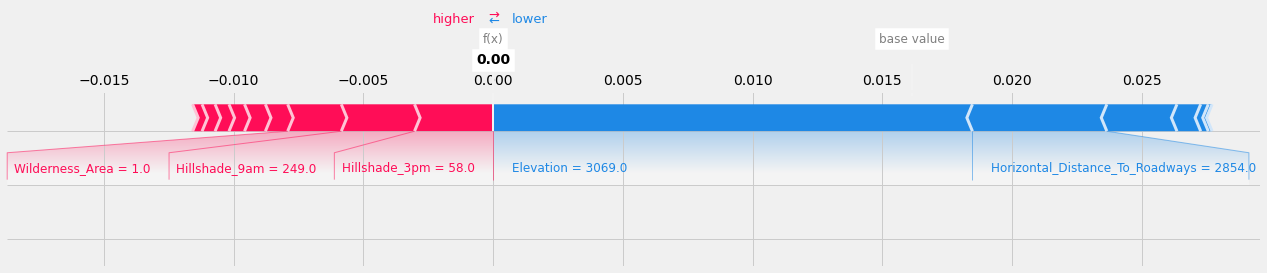

In [47]:
# Save the Shapley Force Plot
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=shap_row,
    show=False, 
    matplotlib=True
).savefig('../assets/shapley_force.png')

## Save the model for the Dash App
I will use the `best_model_rf`. 

In [56]:
dump(best_model_rf, "../assets/pipeline.joblib", compress= True)

['../assets/pipeline.joblib']

# XII. Communicate Results

## Present the Test Metrics

In [43]:
present_test_metrics(best_model_list, X_test, y_test)

Model being Scored: Logistic Regression
>>Testing Accuracy Score: 0.7238195227317711
Model being Scored: Random Forest
>>Testing Accuracy Score: 0.9604743423147423


In [45]:
print(classification_report(y_test, best_model_rf.predict(X_test)))

                   precision    recall  f1-score   support

            Aspen       0.94      0.80      0.87      1995
Cottonwood/Willow       0.92      0.85      0.88       526
      Douglas-fir       0.94      0.91      0.93      3489
        Krummholz       0.97      0.96      0.97      4015
   Lodgepole Pine       0.96      0.98      0.97     56500
   Ponderosa Pine       0.95      0.97      0.96      7121
       Spruce/Fir       0.97      0.95      0.96     42557

         accuracy                           0.96    116203
        macro avg       0.95      0.92      0.93    116203
     weighted avg       0.96      0.96      0.96    116203



## Communicate Results

After hyperparameter tuning and confirming feature importances the Random Forest Classifier is the best model for predicting Cover Type in the Roosevelt National Forest. Although the model performs at 100% on the Training data which would indicate overfitting, the model maintains a high Accuracy for the Validation and Test Sets. Maintaining Accuracy scores above 90% in both.

It is also interesting to not that the model also maintains high Precision, Recall, and the combined F1 score. Though not the metrics I used for determining the effectiveness of the model, it still performs well in these metrics. 

# Appendix: Additional Visualizations

## Chart of the Cover Types

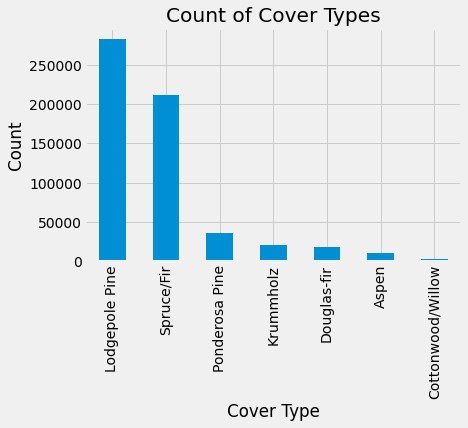

In [54]:
df_wrangled['Cover_Type'].value_counts().plot(kind='bar')


plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.title('Count of Cover Types')
plt.show()